In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using Random
using Distributions
using FFTW
# using Pkg
# Pkg.add("AbstractGPs")
# Pkg.add("LogExpFunctions")
using AbstractGPs, LogExpFunctions, Turing


In [2]:
function meshgrid(x,y)
    n = length(y)
    m = length(x)
    X = Matrix{eltype(x)}(undef, n, m)
    Y = Matrix{eltype(y)}(undef, n, m)
    @views @simd for i in eachindex(y)
        X[i,:] = x
    end
    @views @simd for j in eachindex(x)
        Y[:,j] = y
    end
    return X, Y
end
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(ifft(ifftshift(B)))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end

Autocorrelation (generic function with 1 method)

(150,)
(150,)


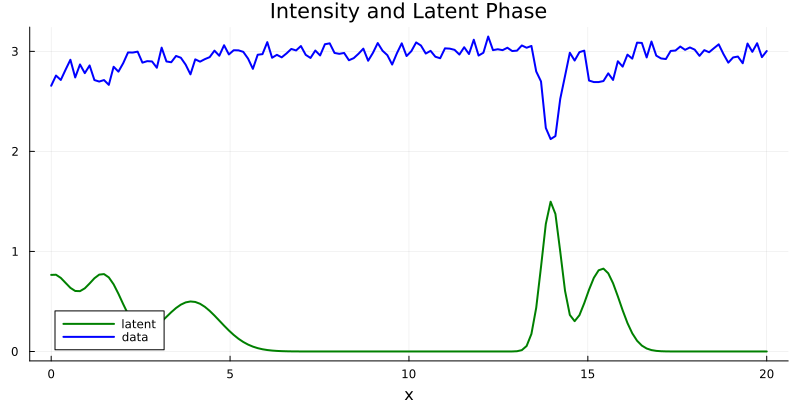

In [3]:
gaussian(x, σ) = @. exp(-x^2 / (2σ^2)) / (σ * sqrt(2π))
Random.seed!(1)
n = 150
N_electrons = 10_00
L = 20
ϵ = 0.01
y_latent = zeros(n)
x_train = collect(LinRange(0.0, L, n))
for i in 1:5
    x0 = rand(Uniform(0, L))
    σ = rand(truncated(Normal(0, 1), 0.1, 1))
    y_latent += gaussian(x_train.-x0, σ) #.+ ϵ * randn(n)
end
# y_latent += ϵ * randn(n)
println(size(y_latent))
println(size(x_train))



Intensity = 2 .+ cos.(y_latent)
y_train = rand.(Poisson.(Intensity*N_electrons))

plot(x_train, y_latent, 
    label = "latent", 
    title = "Intensity and Latent Phase", 
    xlabel = "x", ylabel = "",
    markersize = 2, size = (800, 400), color = :green, linewidth = 2)
plot!(x_train, y_train./N_electrons, 
    label = "data", 
    markersize = 2, 
    color = :blue, linewidth = 2)

In [7]:
using BSplines
using Pkg
# Pkg.add("StatsFuns")
spacing = 2
order = 3  # Cubic B-splines
N_knots = length(x_train[1:spacing:end])
knots_list = x_train[1:spacing:end]
basis = BSplineBasis(order, knots_list)


76-element BSplineBasis{Vector{Float64}}:
 order: 3
 breakpoints: [0.0, 0.268456, 0.536913, 0.805369, 1.07383, 1.34228, 1.61074, 1.87919, 2.14765, 2.41611  …  17.4497, 17.7181, 17.9866, 18.255, 18.5235, 18.7919, 19.0604, 19.3289, 19.5973, 19.8658]

In [ ]:
using ReverseDiff
using Turing
using Distributions
using BSplines
using Statistics: mean, median
using LogExpFunctions

# struct ScaledPoisson{T<:Real} <: Distribution{Univariate,Discrete}
#     λ::T           # rate
#     α::T           # scaling factor
# end
# Distributions.logpdf(d::ScaledPoisson, k::Int) =
#     d.α * logpdf(Poisson(d.λ), k)

# Base.rand(rng::AbstractRNG, d::ScaledPoisson) = rand(rng, Poisson(d.λ))

# Turing.@addlogprob! sum(logistic.(10 .*(spline.(x_input).-0.5)))


@model function latent_model(y, x_input, N_poisson, λ)
    weights ~ filldist(Uniform(-0.5, π), length(basis))
    
    spline = Spline(basis, weights)
    I = @. (2 + cos(spline(x_input)))* N_poisson
    
    Turing.@addlogprob! -λ * inv(length(basis)-1) * sum((diff(weights)).^2)
    Turing.@addlogprob! sum(logpdf.(Poisson.(I), y))  # ← scales by N

    # y ~ arraydist(Poisson.(I))
end
function model_lambda(λ)
    global init_params
    global global_samples
    global weights_2_plot
    model = latent_model(y_train, x_train, N_electrons, λ)
    sampler = Turing.NUTS(max_depth=8; adtype=AutoReverseDiff(true))
    chain = sample(model, sampler, global_samples; progress=true, initial_params=init_params)
    
    # Reconstruct weights_samples as a matrix of size (iterations × n_basis)
    weights_samples = reduce(hcat, [chain[Symbol("weights[$i]")] for i in 1:length(basis)])
    mode_weights = mapslices(x -> median(x), weights_samples, dims=1) |> vec
    init_params = mode_weights
    global_samples = 1000
    reconstructed_spline = Spline(basis, mode_weights)
    latent_phi = reconstructed_spline.(x_train)
    return latent_phi, mode_weights
end
λs = collect(LinRange(0.0, 1000, 10))
global global_samples = 5000
global init_params = ones(length(basis))*0.1
latent_phis = Matrix{Float64}(undef, length(λs), length(x_train))
weights_samples = Matrix{Float64}(undef, length(λs), length(basis))
for (i, λ) in enumerate(λs)
    latent_phis[i, :], weights_samples[i,:] = model_lambda(λ)
end

In [316]:
map_estimate = maximum_a_posteriori(latent_model(y_train, x_train, N_electrons, 10.0),initial_params=init_params)


ModeResult with maximized lp of -1298.08
[0.850570596746989, 0.7290713529504567, 0.5971543513478494, 0.5849055933831673, 0.7525338063625635, 0.7811875685413447, 0.4770849634855659, 0.3161297785452352, 0.3793296523445752, 0.4004386909464937  …  0.013513158306539264, -0.1742184737102691, -0.1746433675287737, -0.08529891928712435, -0.0663080005147291, -0.14621116555911992, -0.2956215909706377, -0.29994409404073985, -0.16268362569501735, -0.003827856208219793]

In [140]:
length(weights_samples[1,:])
length(x_train[1:spacing:end])

75

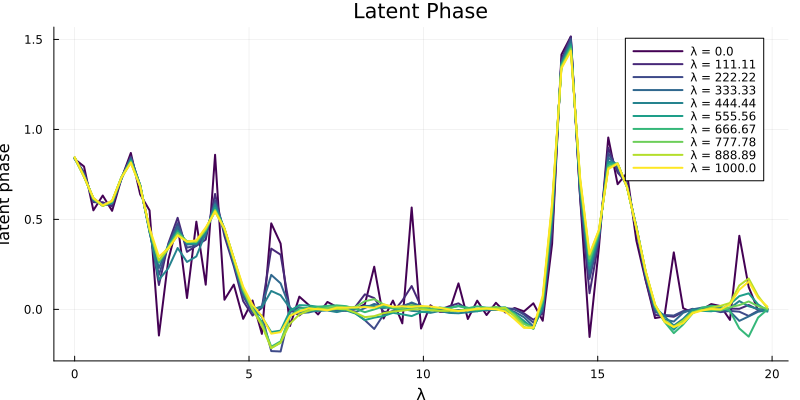

In [154]:
color_gradient = cgrad(:viridis, length(λs), categorical=true)
fig1 = plot()
for (i,lambda_val) in enumerate(λs)
    plot!(x_train[1:spacing:end], weights_samples[i, 1:end-1],
        title = "Latent Phase", 
        xlabel = "λ", 
        ylabel = "latent phase",
        label = "λ = $(round(lambda_val, digits=2))",
        markersize = 2, 
        size = (800, 400),
        color = color_gradient[i],
        linewidth = 2)
end
display(fig1)

In [318]:
println(size(latent_phis))
println(length(x_train))

In [220]:
lp = copy(latent_phis);

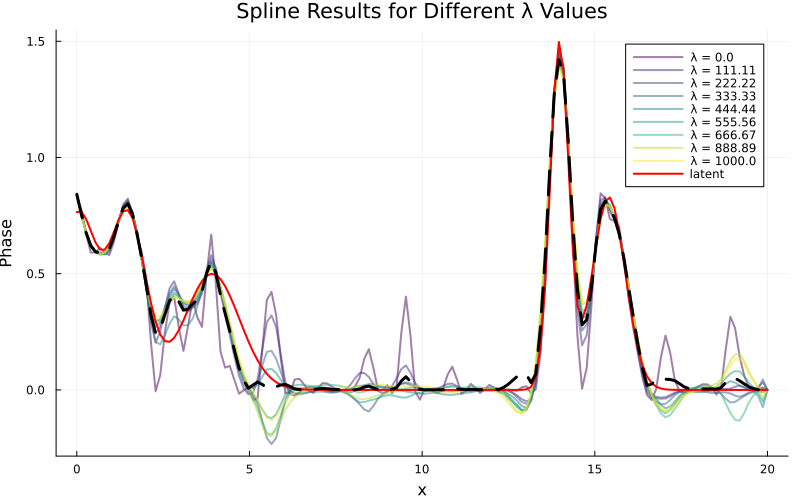

In [174]:
# fig1 = plot() 
color_gradient = cgrad(:viridis, length(λs), categorical=true)

# for (i, lambda_val) in enumerate(λs)
#     plot!(x_train, latent_phis[i, :],
#           label = "λ = $(round(lambda_val, digits=2))",
#           markersize = 2, color = :blue, linewidth = 2)
# end
fig1 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
# latent_phis = abs.(latent_phis)
for (i, lambda_val) in enumerate(λs[1:end])
      i == 8 ? continue :
      plot!(x_train, latent_phis[i, :],
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2, alpha=0.5)
end
plot!(x_train, y_latent,
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
# plot!(legend = false)
plot!(x_train, phis_recovered[1, :],
          label = "",
          markersize = 2, 
          color =:black,  # Use color from gradient
          linewidth = 3, linestyle = :dash)
display(fig1)



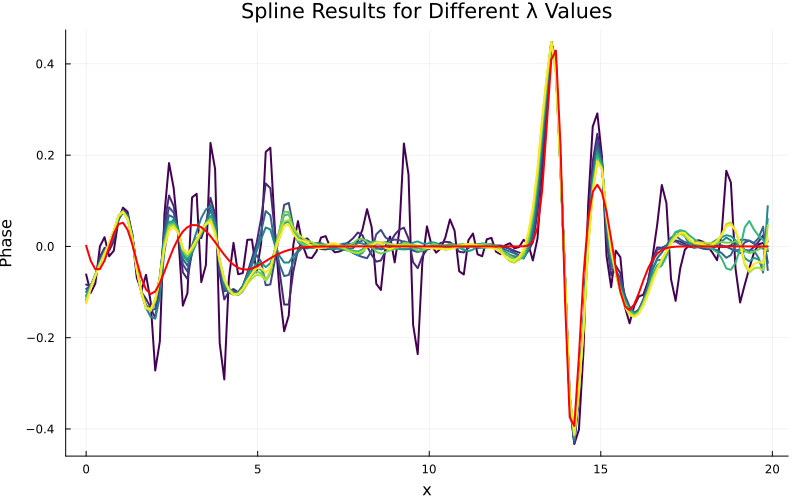

In [156]:
fig2 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
phi_diff = diff(latent_phis[1, :])
phi_d_scale = maximum(phi_diff) 
phi_λ_diff = Matrix{Float64}(undef, length(λs), length(x_train)-1)


for (i, lambda_val) in enumerate(λs)
      phi_diff = diff(latent_phis[i, :])
      phi_diff = phi_diff ./ maximum(phi_diff) * phi_d_scale
      phi_λ_diff[i, :] = phi_diff
      plot!(x_train[1:end-1], phi_diff,
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2)
end
plot!(x_train[1:end-1], diff(y_latent),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig2)

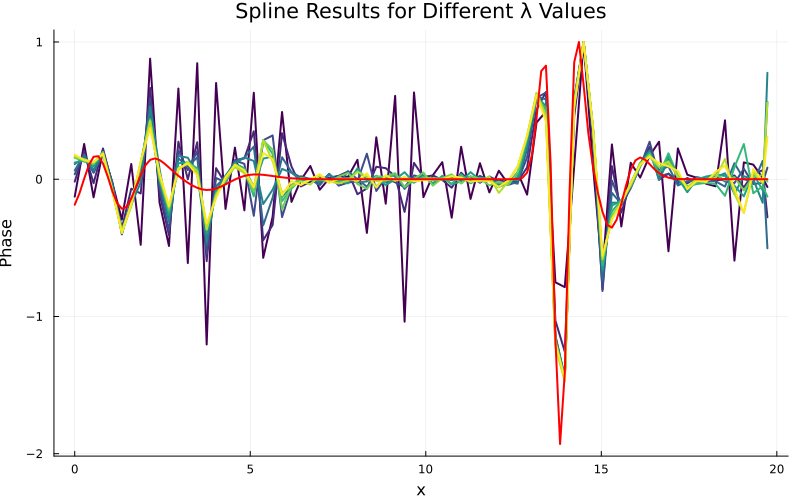

In [157]:
fig3 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
phi_diff = diff(diff(latent_phis[1, :]))
phi_d_scale = maximum(phi_diff) 
phi_λ_diff2 = Matrix{Float64}(undef, length(λs), length(x_train)-2)


for (i, lambda_val) in enumerate(λs)
    phi_diff = diff(diff(latent_phis[i, :]))
    phi_diff = phi_diff ./ maximum(phi_diff) 
    phi_λ_diff2[i, :] = phi_diff
    plot!(x_train[1:end-2], phi_diff,
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2)
end
plot!(x_train[1:end-2], diff(diff(y_latent))./maximum(diff(diff(y_latent))),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig3)

In [158]:
size(phi_λ_diff)

(10, 149)

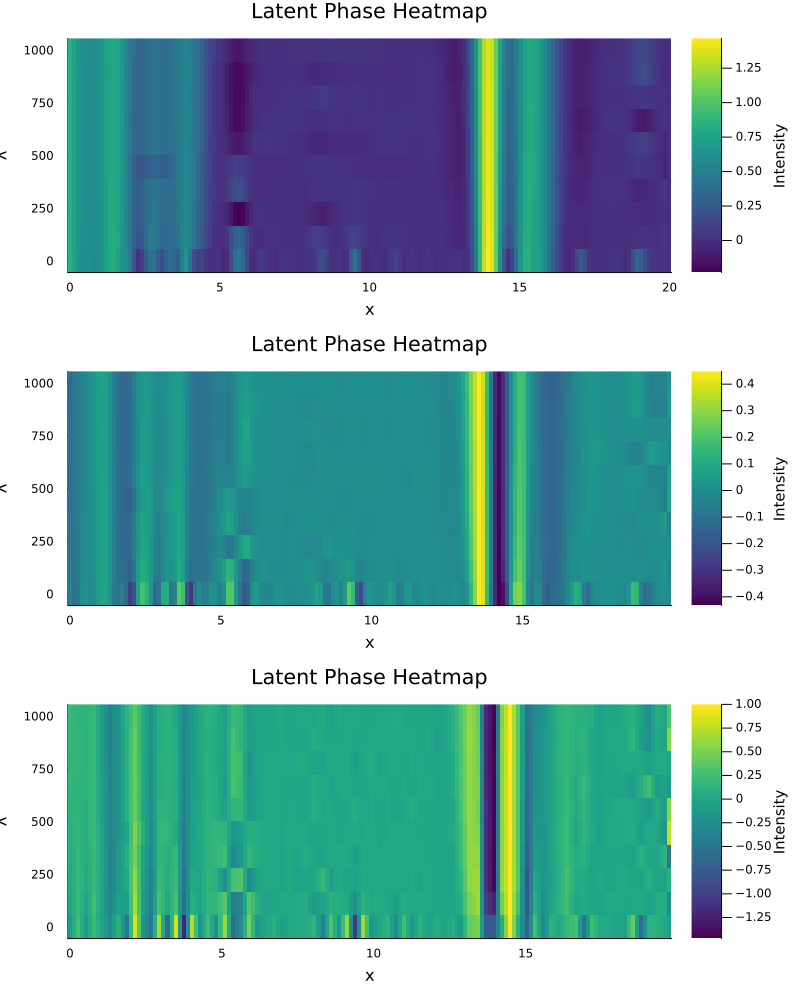

In [169]:
fig1 = heatmap(x_train, λs, latent_phis, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig2 = heatmap(x_train[1:end-1], λs, phi_λ_diff, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig3 = heatmap(x_train[1:end-2], λs, phi_λ_diff2, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
plot(fig1, fig2, fig3, layout = (3, 1), 
     size = (800, 1000), 
     title = "Latent Phase Heatmap", 
     xlabel = "x", ylabel = "λ", 
     colorbar_title = "Intensity")

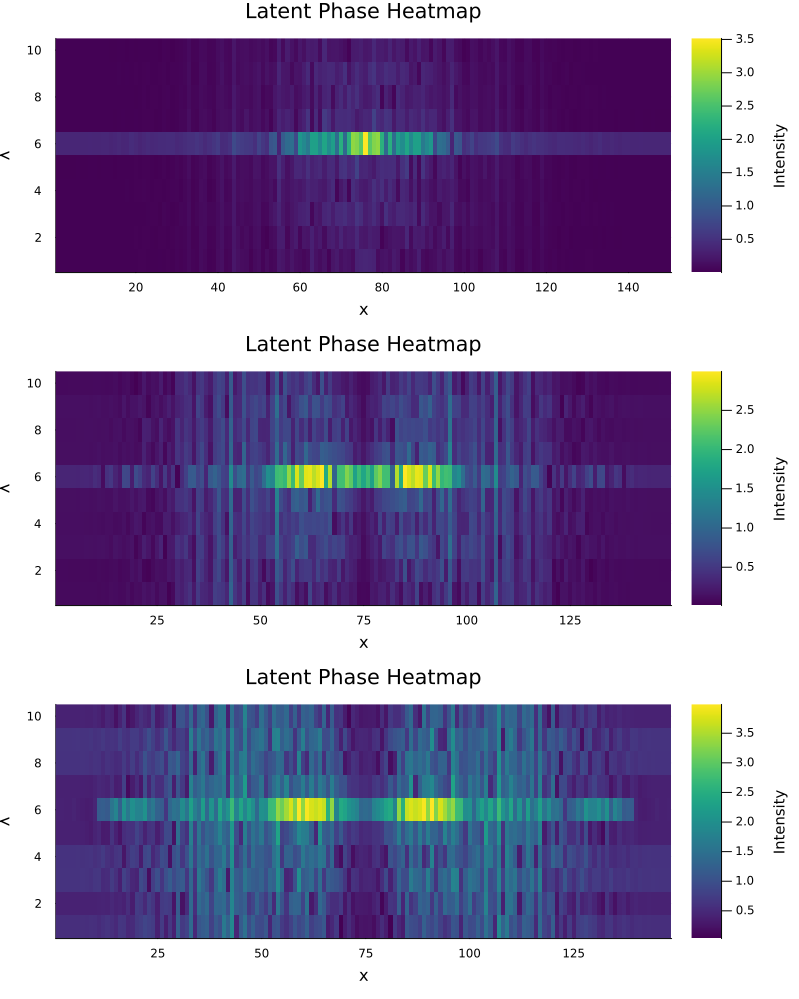

In [160]:
conv(x, c=0.5) = log.(1 .+ c.*abs.(fftnshift(x)))
fig1 = heatmap(conv(latent_phis,0.1), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig2 = heatmap(conv(phi_λ_diff), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig3 = heatmap(conv(phi_λ_diff2), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
plot(fig1, fig2, fig3, layout = (3, 1), 
     size = (800, 1000), 
     title = "Latent Phase Heatmap", 
     xlabel = "x", ylabel = "λ", 
     colorbar_title = "Intensity")

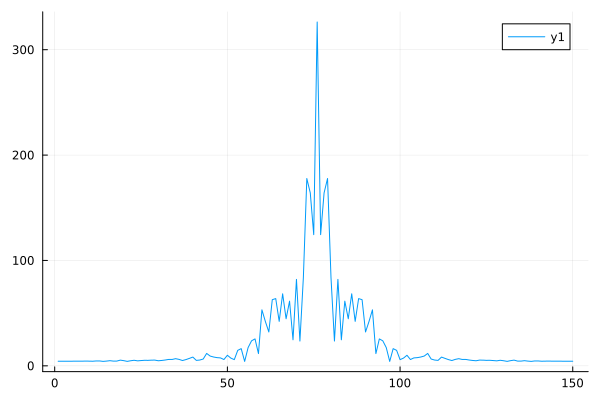

In [170]:
idx = length(λs) ÷ 2 +1
plot(abs.(fft_phis[idx,:]))

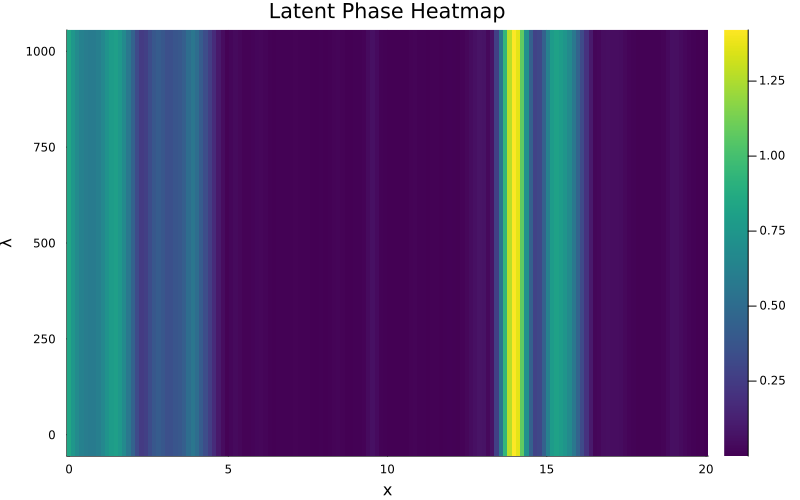

In [171]:

N_window = 0
fft_phis = fftnshift(latent_phis)
filtered_fft = copy(fft_phis)
filtered_fft .= 0
filtered_fft[idx-N_window:idx+N_window,:] = fft_phis[idx-N_window:idx+N_window,:]
# fft_phis[end÷2-N_window:end÷2+N_window,:] .= 0
phis_recovered = ifftnshift(filtered_fft)
fig1 = heatmap(x_train, λs, abs.(phis_recovered), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)

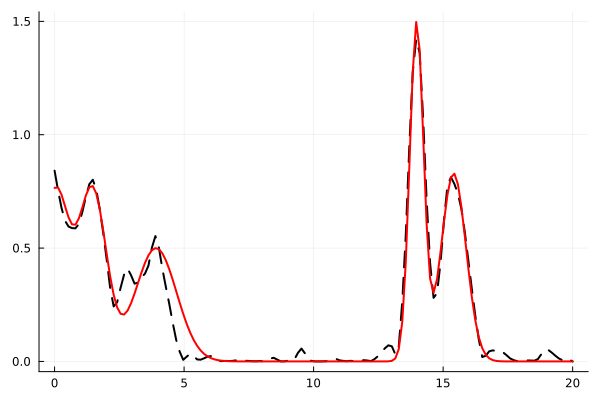

In [172]:
original_energy = sum(abs2.(filtered_fft))

idx =0 #+  length(λs) ÷ 2 
# phis_recovered = abs.(ifftnshift(filtered_fft[10:end,:]))
filtered_energy = sum(abs2.(filtered_fft[1:end-idx,:]))
scale_factor = sqrt(original_energy / filtered_energy)
phis_recovered = abs.(ifftnshift(filtered_fft[1:end-idx,:].* scale_factor)) 
fig1 = plot()

# for (i, lambda_val) in enumerate(λs)
#     plot!(x_train, phis_recovered[i, :],
#           label = "λ = $(round(lambda_val, digits=2))",
#           markersize = 2, 
#           color = color_gradient[i],  # Use color from gradient
#           linewidth = 2)
# end
plot!(x_train, phis_recovered[1, :],
          label = "",
          markersize = 2, 
          color =:black, linestyle=:dash,  # Use color from gradient
          linewidth = 2)
plot!(x_train, y_latent,
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig1)


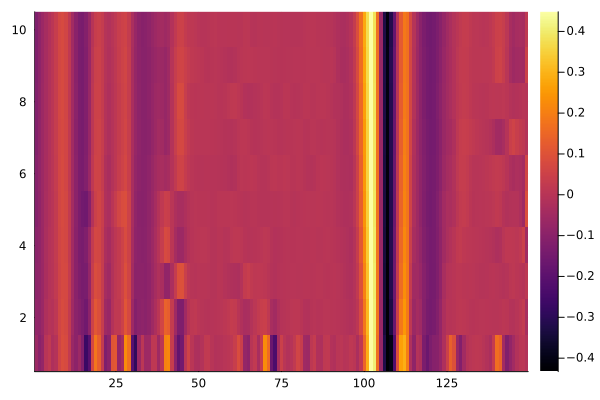

In [164]:
heatmap(phi_λ_diff)

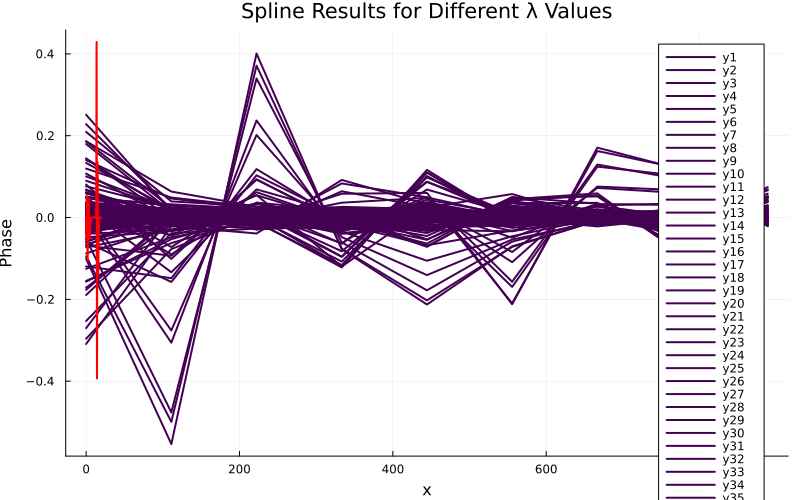

In [165]:
fig2 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
# phi_diff = diff(latent_phis[1, :])
# phi_d_scale = maximum(phi_diff) 


phi_diff = diff(latent_phis, dims=1)
# phi_diff = phi_diff ./ maximum(phi_diff) * phi_d_scale
plot!(λs[1:end-1], phi_diff,
        markersize = 2, 
        color = color_gradient,  # Use color from gradient
        linewidth = 2)

plot!(x_train[1:end-1], diff(y_latent),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
display(fig2)

In [166]:
using StatsPlots
plot(chain[:,1:5,:], 
    vars = [:v, :l, :jitter], 
    title = "Posterior distributions", 
    label = ["v" "l" "jitter"], 
    legend = false)

UndefVarError: UndefVarError: `chain` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing IterTools in the current active module Main

In [167]:
using Statistics, Plots, Unwrap

n_weights = length(basis)
# n_iter, n_weights = size(weights_samples)

n_basis = length(basis)  # Should be 41

# Reconstruct weights_samples as a matrix of size (iterations × n_basis)
weights_samples = reduce(hcat, [chain[Symbol("weights[$i]")] for i in 1:n_basis])
using StatsBase
mode_weights = mapslices(x -> median(x), weights_samples, dims=1) |> vec

# Then build the spline
reconstructed_spline = Spline(basis, mode_weights)
I_recon = (2 .+ cos.(reconstructed_spline.(x_train))) 

# I_latent = unwrap(acos.(I_recon .- 2))
# I_latent = (I_recon .- 2)

p = plot(x_train, zeros(length(x_train)),
    xlabel="x", ylabel="",
    title="Multiple BSpline Reconstructions", label="", lw=1, color=:gray)

# Plot a subset of the reconstructions to avoid clutter.
for i in 100:1:length(chain[:,1,1])
    w = weights_samples[i, :]          # current weights sample
    spline_i = Spline(basis, w)          # build spline
    I_recon_i = (spline_i.(x_train)) # evaluate at x_train
    # I_recon_i = unwrap(acos.(clamp.(I_recon_i,-1,1)))
    plot!(p, x_train, I_recon_i, lw=1, label="", alpha=0.01, color=:red)
end
ylims!(-.1, 3.2)
plot!(x_train,reconstructed_spline.(x_train),
    label = "Inferred Phase", 
    markersize = 2, 
    color = :black, linewidth = 2, linestyle = :dash)
plot!(x_train, y_train./N_electrons, 
    label = "", 
    markersize = 2, 
    color = :blue, linewidth = 2)
# plot!(x_train, (y_latent),
#     label = "True Intensity", 
#     markersize = 2, 
#     color = :green, linewidth = 2)
plot!(x_train, y_latent,
    label = "", 
    markersize = 2, 
    color = :green, linewidth = 2)

UndefVarError: UndefVarError: `chain` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing IterTools in the current active module Main

In [168]:
plot(fig5, fig4, fig1, fig2, fig3, layout = (1,5), size = (1200, 400), 
    title = "First Derivative", 
    xlabel = "x", ylabel = "dφ/dx", 
    label = "", legend = false)

UndefVarError: UndefVarError: `fig5` not defined in `Main`
Suggestion: check for spelling errors or missing imports.